# Analyse Des Sentiments : Étude Comparative

## Objectif
Ce projet vise à comparer les performances de différents modèles de Machine Learning et de Deep Learning pour la tâche d'analyse de sentiments. Nous explorerons des modèles classiques (e.g., régression logistique, forêts aléatoires) ainsi que des architectures plus avancées (e.g., réseaux de neurones, LLMs). L'objectif est d'identifier le modèle le plus performant pour la classification des sentiments (positif, négatif, neutre) sur un jeu de données textuelles.

---

## Plan du Notebook
1. **Installation des bibliothèques**
2. **Chargement des données**
3. **Prétraitement des données**
4. **Analyse exploratoire des données (EDA)**
5. **Ingénierie des caractéristiques (Feature Engineering)**
6. **Entraînement et évaluation des modèles**

---

## 1. Installation des bibliothèques

In [2]:
# Installation des dépendances
!pip install textblob wordcloud imblearn transformers peft datasets accelerate bitsandbytes torch ollama


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Utilité
import random
import os

# Data 
import kagglehub

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLP
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel


# EDA analysis
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

# Models ML
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier


# Evaluation et Tuning
from sklearn.model_selection import cross_val_score

# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Neural Networks
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

c:\Users\amine\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Chargement des données

In [4]:
# Chargement des données
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')
train_dataset = path + '/train.csv'
test_dataset = path + '/test.csv'

if os.path.exists(train_dataset) and os.path.exists(test_dataset):
    train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
    test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')
    print("Dataset importé avec succès")

# Affichage des dimensions
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
train_df.head()

Dataset importé avec succès
Train shape: (27481, 10), Test shape: (4815, 9)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## 3. Prétraitement des données
### 3.1 Gestion des valeurs manquantes
Les valeurs manquantes sont supprimées car elles sont négligeables et ne permettent pas une imputation significative.

In [5]:
train_df.isnull().sum(), test_df.isnull().sum()

(textID              0
 text                1
 selected_text       1
 sentiment           0
 Time of Tweet       0
 Age of User         0
 Country             0
 Population -2020    0
 Land Area (Km²)     0
 Density (P/Km²)     0
 dtype: int64,
 textID              1281
 text                1281
 sentiment           1281
 Time of Tweet       1281
 Age of User         1281
 Country             1281
 Population -2020    1281
 Land Area (Km²)     1281
 Density (P/Km²)     1281
 dtype: int64)

In [6]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

### 3.2 Nettoyage du texte
Le texte est nettoyé en supprimant les ponctuations, les chiffres, les liens, et en convertissant tout en minuscules.

In [7]:
def clean_text(text):
    text = text.lower()
    punc = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(punc)
    text = re.sub(r'\d+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    return text

# Application du nettoyage
train_df["processed_text"] = train_df["text"].apply(clean_text)
test_df["processed_text"] = test_df["text"].apply(clean_text)

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
C:\Users\amine\AppData\Local\Temp\ipykernel_5276\1115560726.py:6: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)


In [8]:
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) - set(["not"])

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

train_df["processed_text"] = train_df["processed_text"].apply(remove_stopwords)
test_df["processed_text"] = test_df["processed_text"].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

## 4. Analyse exploratoire des données (EDA)
### 4.1 Distribution des sentiments
Nous visualisons la distribution des sentiments dans les ensembles d'entraînement et de test.

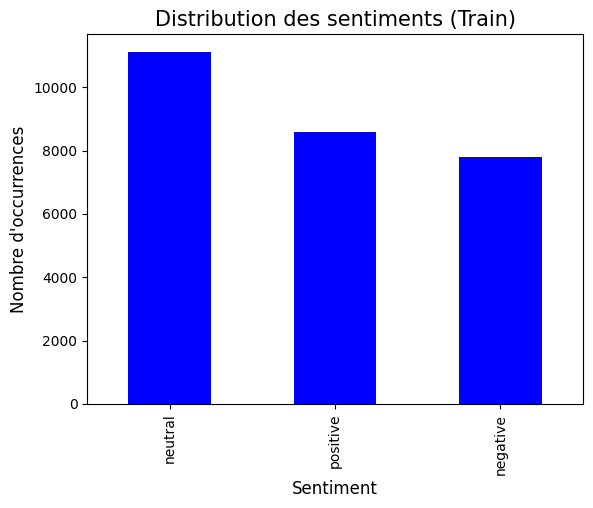

In [9]:
# Distribution des sentiments
train_df["sentiment"].value_counts().plot(kind="bar", color="blue")
plt.title("Distribution des sentiments (Train)", fontsize=15)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Nombre d'occurrences", fontsize=12)
plt.show()

### 4.2 Longueur des textes et nombre de mots
Nous analysons la longueur des textes et le nombre de mots pour comprendre la complexité des données.

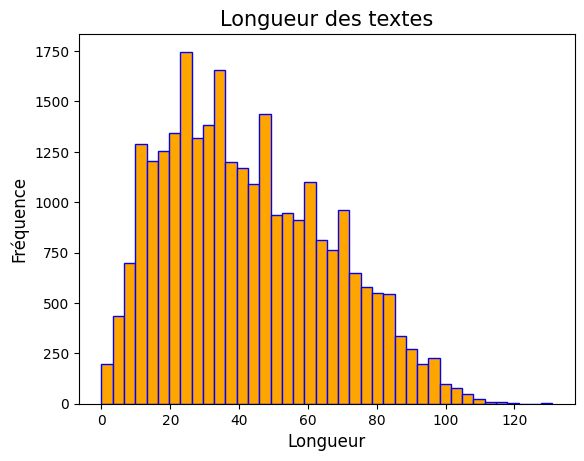

In [10]:
train_df["text_length"] = train_df["processed_text"].apply(len)

train_df["text_length"].plot(kind="hist", bins=40, edgecolor="blue", linewidth=1, color="orange")
plt.title("Longueur des textes", fontsize=15)
plt.xlabel("Longueur", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.show()

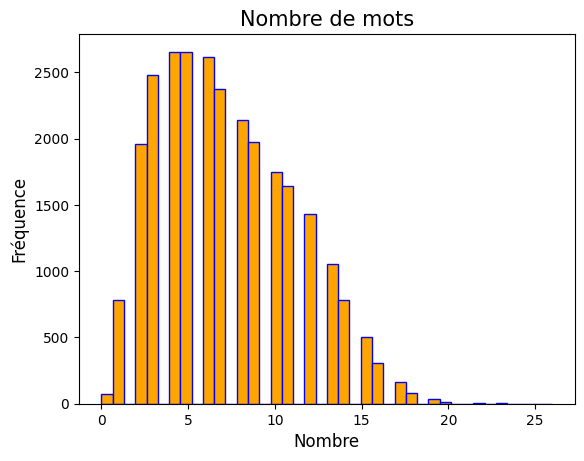

In [11]:
train_df["word_count"] = train_df["processed_text"].apply(lambda x: len(str(x).split()))

train_df["word_count"].plot(kind="hist", bins=40, edgecolor="blue", linewidth=1, color="orange")
plt.title("Nombre de mots", fontsize=15)
plt.xlabel("Nombre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.show()

### 4.3 Polarité des entrées
le polarity score est une valeur numérique, calculée par la bibliothèque TextBlob, qui mesure le sentiment d'un texte. Ce score appartient à l'intervalle [−1,1] et indique le degré de positivité, de négativité ou de neutralité du texte.


In [12]:
train_df["polarity"] = train_df["processed_text"].map(lambda Text: TextBlob(Text).sentiment.polarity)

In [13]:
test_df["polarity"] = test_df["processed_text"].map(lambda Text: TextBlob(Text).sentiment.polarity)

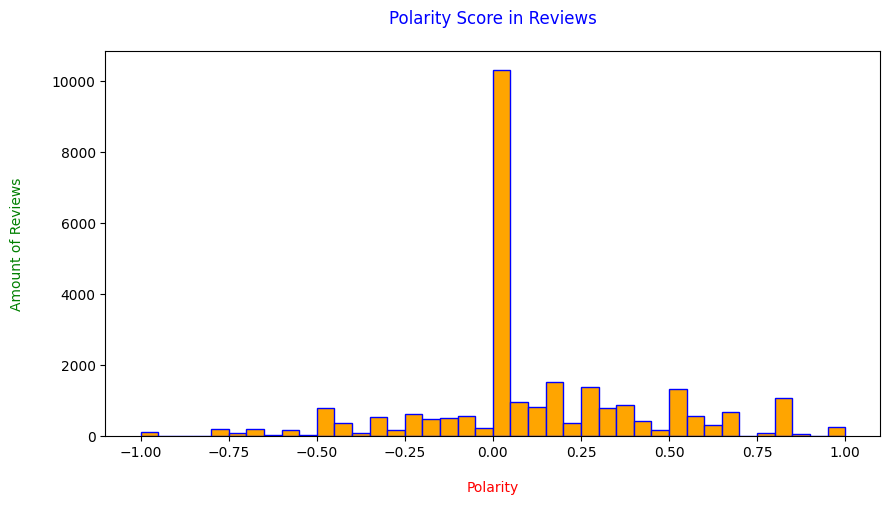

In [14]:
train_df["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")
plt.savefig("plots/polarity_train.png", dpi=300, bbox_inches='tight')

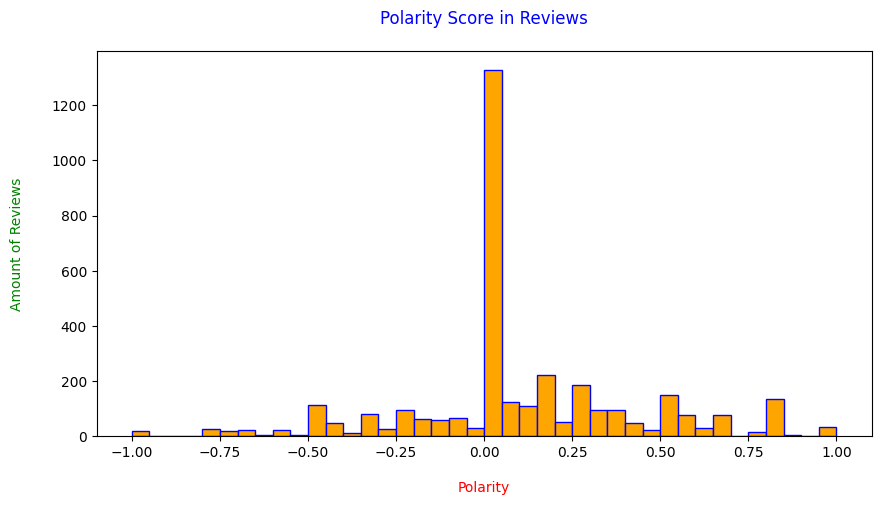

In [15]:
test_df["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")
plt.savefig("plots/polarity_test.png", dpi=300, bbox_inches='tight')

---

## 5. Ingénierie des caractéristiques (Feature Engineering)
### 5.1 Encodage des labels
Les labels de sentiment sont encodés en valeurs numériques.

In [16]:
# Encodage des labels
label_encoder = LabelEncoder()
train_df["sentiment"] = label_encoder.fit_transform(train_df["sentiment"])
test_df["sentiment"] = label_encoder.transform(test_df["sentiment"])

### 5.2 Selection des features
On choisira `processed_text` comme entrée et `sentiment` comme sortie

In [17]:
columns = ['processed_text', 'sentiment']
train_df = train_df[columns]
test_df = test_df[columns]
train_df.head()

,processed_text,sentiment
0,responded going,1
1,sooo sad miss san diego,0
2,boss bullying,0
3,interview leave alone,0
4,sons put releases already bought,0


### 5.3 Tokenisation et Génération des embeddings avec BERT

- Conversion du texte brut et le convertira en une représentation adaptée au modèle BERT
- Nous utilisons les embeddings de BERT pour représenter les textes. Cela permet d'obtenir des représentations plus riches et contextuelles.


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : cuda


In [19]:
PRETRAINED_MODEL = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [20]:
def tokenize_text(text):
    return tokenizer(
        text,
        padding='max_length',  # On remplit jusqu'à la longueur max
        truncation=True,       # On tronque si le texte dépasse la longueur max
        max_length=128,        # Longueur maximale
        return_tensors="pt"   # Retourne des tenseurs PyTorch
    )

In [21]:
train_df['tokenized'] = train_df['processed_text'].apply(lambda x: tokenize_text(x))
test_df['tokenized'] = test_df['processed_text'].apply(lambda x: tokenize_text(x))

# Extraction des input_ids et attention_mask
train_df['input_ids'] = train_df['tokenized'].apply(lambda x: x['input_ids'].squeeze(0))
train_df['attention_mask'] = train_df['tokenized'].apply(lambda x: x['attention_mask'].squeeze(0))

test_df['input_ids'] = test_df['tokenized'].apply(lambda x: x['input_ids'].squeeze(0))
test_df['attention_mask'] = test_df['tokenized'].apply(lambda x: x['attention_mask'].squeeze(0))

print("Tokenisation terminée.")
print("Exemple input_ids (train) :", train_df['input_ids'].iloc[0].shape)

Tokenisation terminée.
Exemple input_ids (train) : torch.Size([128])


In [ ]:
batch_size = 32
train_embeddings_list = []

with torch.no_grad():
    for i in range(0, len(train_df), batch_size):
        batch = train_df.iloc[i:i+batch_size]
        input_ids = torch.stack(batch['input_ids'].tolist()).to(device)
        attention_mask = torch.stack(batch['attention_mask'].tolist()).to(device)
        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]
        train_embeddings_list.append(pooled_output.cpu())

# Concaténation de tous les batchs
train_embeddings = torch.cat(train_embeddings_list, dim=0)

# On stocke les embeddings dans une nouvelle colonne
train_df['embeddings'] = train_embeddings.tolist()

print("Nombre d'instances d'entraînement :", len(train_df))
print("Taille de la première embedding :", len(train_df['embeddings'].iloc[0]))

Nombre d'instances d'entraînement : 27480
Taille de la première embedding : 768


In [29]:
test_embeddings_list = []


with torch.no_grad():
    for i in range(0, len(test_df), batch_size):
        batch = test_df.iloc[i:i+batch_size]
        input_ids = torch.stack(batch['input_ids'].tolist()).to(device)
        attention_mask = torch.stack(batch['attention_mask'].tolist()).to(device)
        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]
        test_embeddings_list.append(pooled_output.cpu())

# Concatenating all batches
test_embeddings = torch.cat(test_embeddings_list, dim=0)

# Storing embeddings in a new column
test_df['embeddings'] = test_embeddings.tolist()

print("Nombre d'instances de test :", len(test_df))
print("Taille de la première embedding :", len(test_df['embeddings'].iloc[0]))

Nombre d'instances de test : 3534
Taille de la première embedding : 768


In [30]:
df = pd.concat([train_df, test_df], axis=0)
# df.to_csv('processed_data.csv')
df.head()

,processed_text,sentiment,tokenized,input_ids,attention_mask,embeddings
0,responded going,1,"[input_ids, token_type_ids, attention_mask]","[tensor(101), tensor(5838), tensor(2183), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[-0.8226425051689148, -0.21082709729671478, 0...."
1,sooo sad miss san diego,0,"[input_ids, token_type_ids, attention_mask]","[tensor(101), tensor(17111), tensor(2080), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[-0.8626494407653809, -0.4829854667186737, -0...."
2,boss bullying,0,"[input_ids, token_type_ids, attention_mask]","[tensor(101), tensor(5795), tensor(18917), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[-0.7897495627403259, -0.18976107239723206, 0...."
3,interview leave alone,0,"[input_ids, token_type_ids, attention_mask]","[tensor(101), tensor(4357), tensor(2681), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[-0.8291894197463989, -0.23166592419147491, 0...."
4,sons put releases already bought,0,"[input_ids, token_type_ids, attention_mask]","[tensor(101), tensor(4124), tensor(2404), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[-0.8078674674034119, -0.2772521376609802, 0.2..."


## 5.4 Préparation des Données pour l'Entraînement
 
Nous allons maintenant extraire les embeddings et les labels, et si besoin appliquer une stratégie de rééquilibrage comme **SMOTE**.


In [31]:
X = np.array(train_df['embeddings'].tolist())
y = train_df['sentiment'].values

print("Répartition initiale :", Counter(y))

# Sur-échantillonnage avec SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
print("Répartition après SMOTE :", Counter(y_res))

# Mise à jour
X, y = X_res, y_res

Répartition initiale : Counter({np.int64(1): 11117, np.int64(2): 8582, np.int64(0): 7781})


c:\Users\amine\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\amine\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\amine\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\amine\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

Répartition après SMOTE : Counter({np.int64(1): 11117, np.int64(0): 11117, np.int64(2): 11117})


## 6. Entraînement et évaluation des modèles

Dans cette section, nous utilisons les embeddings BERT générés pour entraîner différents modèles de Machine Learning classiques. 
Nous effectuons également une recherche d'hyperparamètres (Grid Search ou Randomized Search) afin d'optimiser les performances.

### 6.1 Modèles ML

In [32]:
# Initialize models
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
svm = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

# Models dictionary for reference
Models = [DTree, LogReg, svm, RForest, Bayes, KNN]
Models_Dict = {
    0: "Decision Tree",
    1: "Logistic Regression",
    2: "SVC",
    3: "Random Forest",
    4: "Naive Bayes",
    5: "K-Neighbors"
}

In [33]:
# Séparation du dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# Ensemble plus réduit pour évaluation rapide
_, X_lim, _, y_lim = train_test_split(X, y, test_size=0.03, random_state=42)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}
Best Accuracy for Decision Tree: 0.5149979625363578

In [34]:
param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_dtree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dtree, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_dtree.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", grid_dtree.best_params_)
print("Best Accuracy for Decision Tree:", grid_dtree.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
Best Accuracy for Decision Tree: 0.5078335832083958


Best Parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(4.6415888336127775)}
Best Accuracy for Logistic Regression: 0.6817571490131886

In [94]:
# Define the parameter grid with a wider range for random sampling
param_dist_logreg = {
    'C': np.logspace(-2, 2, 10),  # Generate 10 values between 0.01 and 100
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# RandomizedSearchCV with fewer combinations
random_logreg = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_dist_logreg,
    n_iter=5,  # Reduce the number of combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_logreg.fit(X_train, y_train)

# Print the results
print("Best Parameters for Logistic Regression:", random_logreg.best_params_)
print("Best Accuracy for Logistic Regression:", random_logreg.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(4.6415888336127775)}
Best Accuracy for Logistic Regression: 0.6817571490131886


In [36]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    
    precision = report["weighted avg"]["precision"] * 100
    recall = report["weighted avg"]["recall"] * 100
    f1_score = report["weighted avg"]["f1-score"] * 100
    accuracy = accuracy_score(y_test, y_pred) * 100



    return {
        "Exactitude": f"{accuracy:.2f}%",
        "Précision": f"{precision:.2f}%",
        "Rappel": f"{recall:.2f}%",
        "Score F1": f"{f1_score:.2f}%"
    }

In [37]:
optimal_logreg = LogisticRegression(solver='liblinear', penalty='l2', C=4.6415888336127775)

# Fit the model to the training data
optimal_logreg.fit(X_train, y_train)

metrics = evaluate_model(optimal_logreg, X_test, y_test)
print("Best Parameters for Logistic Regression:")
for key, value in metrics.items():
    print(f"{key}: {value}")

Best Parameters for Logistic Regression:
Exactitude: 67.13%
Précision: 66.98%
Rappel: 67.13%
Score F1: 67.04%


In [38]:
metrics = evaluate_model(optimal_logreg, X_lim, y_lim)
print("Best Parameters for Logistic Regression:")
for key, value in metrics.items():
    print(f"{key}: {value}")

Best Parameters for Logistic Regression:
Exactitude: 66.13%
Précision: 65.92%
Rappel: 66.13%
Score F1: 65.96%


Best Parameters for SVM: {'kernel': 'linear', 'gamma': 'auto', 'C': np.float64(1.0)}
Best Accuracy for SVM: 0.6606060606060606

In [ ]:
# Define the parameter distribution for random search
param_dist_svm = {
    'C': np.logspace(-2, 2, 5),  # Generate 5 logarithmically spaced values between 0.01 and 100
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# RandomizedSearchCV with fewer combinations
random_svm = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist_svm,
    n_iter=5,  # Reduce the number of combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_svm.fit(X_train, y_train)

# Print the results
print("Best Parameters for SVM:", random_svm.best_params_)
print("Best Accuracy for SVM:", random_svm.best_score_)

In [137]:
# Define the optimized SVM model with the given parameters
optimal_svm = SVC(kernel='linear', gamma='auto', C=1.0)

# Fit the model to the training data
optimal_svm.fit(X_train, y_train)

metrics = evaluate_model(optimal_svm, X_test, y_test)
print("Best Parameters for SVM:")
for key, value in metrics.items():
    print(f"{key}: {value}")


[2 2 1 ... 0 2 2]
Best Parameters for SVM:
Exactitude: 67.83%
Précision: 67.72%
Rappel: 67.83%
Score F1: 67.74%


In [138]:
metrics = evaluate_model(optimal_svm, X_lim, y_lim)
print("Best Parameters for SVM:")
for key, value in metrics.items():
    print(f"{key}: {value}")

[2 2 1 ... 0 0 0]
Best Parameters for SVM:
Exactitude: 65.75%
Précision: 65.53%
Rappel: 65.75%
Score F1: 65.50%


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy for Random Forest: 0.6764709788816576

In [ ]:
param_grid_rforest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rforest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rforest, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rforest.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_rforest.best_params_)
print("Best Accuracy for Random Forest:", grid_rforest.best_score_)


In [139]:

# Define the optimized Random Forest model with the given parameters
optimal_rf = RandomForestClassifier(max_depth=None, min_samples_split=5, n_estimators=200, random_state=42)

# Fit the model to the training data
optimal_rf.fit(X_train, y_train)

metrics = evaluate_model(optimal_rf, X_test, y_test)
print("Best Parameters for Random Forest:")
for key, value in metrics.items():
    print(f"{key}: {value}")

[2 1 0 ... 2 2 2]
Best Parameters for Random Forest:
Exactitude: 65.97%
Précision: 65.77%
Rappel: 65.97%
Score F1: 65.83%


In [140]:
metrics = evaluate_model(optimal_rf, X_lim, y_lim)
print("Best Parameters for Random Forest:")
for key, value in metrics.items():
    print(f"{key}: {value}")

[2 1 0 ... 0 2 1]
Best Parameters for Random Forest:
Exactitude: 65.58%
Précision: 65.45%
Rappel: 65.58%
Score F1: 65.50%


Best Parameters for Naive Bayes: {'alpha': 0.1}
Best Accuracy for Naive Bayes: 0.383677322641507

In [70]:
param_grid_bayes = {
    'alpha': [0.1, 0.5, 1, 5, 10]
}

grid_bayes = GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid_bayes, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_bayes.fit(X_train, y_train)

print("Best Parameters for Naive Bayes:", grid_bayes.best_params_)
print("Best Accuracy for Naive Bayes:", grid_bayes.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Naive Bayes: {'alpha': 0.1}
Best Accuracy for Naive Bayes: 0.383677322641507


Best Parameters for K-Neighbors: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best Accuracy for K-Neighbors: 0.612259348866988

In [69]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Minkowski distance (1=Manhattan, 2=Euclidean)
}

grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)

print("Best Parameters for K-Neighbors:", grid_knn.best_params_)
print("Best Accuracy for K-Neighbors:", grid_knn.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for K-Neighbors: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best Accuracy for K-Neighbors: 0.612259348866988


## 6.2 Réseaux de Neurones et Optimisation avec Optuna
Dans cette section, nous proposons deux architectures de réseaux de neurones (`SimpleMLP` et `BetterMLP`), ainsi qu'une procédure d'entraînement basée sur PyTorch. 


In [39]:
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.embeddings = torch.tensor(np.array(df['embeddings'].to_list()), dtype=torch.float32)
        self.labels = torch.tensor(df['sentiment'].astype(int).values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]  # Ensure it returns a tuple


In [40]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0, activation="relu"):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Activation function selection
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose from 'relu', 'tanh', 'sigmoid'.")

        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)  # Apply activation function
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x


In [41]:

class BetterMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=3, dropout=0.3, activation="relu"):
        super(BetterMLP, self).__init__()

        # Activation function selection
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose from 'relu', 'tanh', 'sigmoid'.")

        # Fully connected layers with decreasing sizes
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, hidden_dim // 8)
        self.fc5 = nn.Linear(hidden_dim // 8, hidden_dim // 16)
        self.fc6 = nn.Linear(hidden_dim // 16, output_dim)
        

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout / 2)  # Reduce dropout rate for later layers

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.activation(x)

        x = self.fc4(x) 
        x = self.activation(x)

        x = self.fc5(x)
        x = self.activation(x)
        
        x = self.fc6(x)

        return x

In [42]:
def train(model, train_loader, optimizer, criterion, epoch, log_interval=50):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, target) in enumerate(train_loader):  # ✅ Unpack tuple instead of indexing dict
        inputs, target = inputs.cuda(), target.cuda()  # Move to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % log_interval == 0:
            print(f"| Epoch [{epoch}] Iter[{batch_idx}/{len(train_loader)}]\t Loss: {loss.item():.4f} Acc@1: {100. * correct / total:.2f}%")

    return total_loss / len(train_loader), 100. * correct / total


def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, target in test_loader: 
            inputs, target = inputs.cuda(), target.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, target)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / total
    return total_loss / len(test_loader), accuracy

In [43]:
def training_process(df, hidden_dim, learning_rate, batch_size=64, epochs=50, dropout=0.0, activation="relu", optimizer_choice="adam", log_interval=50, patience=5):
    # Split the DataFrame into training and testing datasets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Create PyTorch datasets and dataloaders
    train_dataset = SentimentDataset(train_df)
    test_dataset = SentimentDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = len(df['embeddings'].iloc[0])
    output_dim = len(df['sentiment'].unique())

    model = BetterMLP(input_dim, hidden_dim, output_dim, dropout, activation).to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if optimizer_choice == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_choice == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer. Choose from 'adam', 'sgd', 'rmsprop'.")

    # Training and testing loop with Early Stopping
    best_test_acc = 0
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch, log_interval)
        test_loss, test_acc = test(model, test_loader, criterion)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

        # Early Stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs. Best test accuracy: {best_test_acc:.2f}%")
            break

    return model, train_acc, best_test_acc


In [44]:
def random_search_tuning(df, param_dist, n_iter=20, log_interval=50):
    best_model = None
    best_accuracy = 0
    best_params = None

    for i in range(n_iter):
        # Randomly sample hyperparameters
        params = {key: random.choice(values) for key, values in param_dist.items()}
        print(f"Iteration {i+1}/{n_iter} - Params: {params}")

        # Train and evaluate the model with sampled parameters
        model, train_acc, test_acc = training_process(
            df,
            hidden_dim=params['hidden_dim'],
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            dropout=params['dropout'],
            log_interval=log_interval,
            patience=10
        )

        # Track the best model
        if test_acc > best_accuracy:
            best_model = model
            best_accuracy = test_acc
            best_params = params

    print(f"Best Parameters: {best_params}")
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")
    return best_model, best_params, best_accuracy


In [ ]:
# Extended Random Search hyperparameter distribution
param_dist = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'hidden_dim': [64, 128, 256],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 50],
    'dropout': [0.0, 0.2, 0.5]
}


# Call the random search function
best_model, best_params, best_accuracy = random_search_tuning(df, param_dist, n_iter=10)

In [45]:
model, _, _ = training_process(df, 256, 1e-3, dropout=0.1)

| Epoch [1] Iter[0/388]	 Loss: 1.1124 Acc@1: 29.69%
| Epoch [1] Iter[50/388]	 Loss: 1.0640 Acc@1: 40.56%
| Epoch [1] Iter[100/388]	 Loss: 1.0789 Acc@1: 40.84%
| Epoch [1] Iter[150/388]	 Loss: 1.0810 Acc@1: 40.94%
| Epoch [1] Iter[200/388]	 Loss: 1.0461 Acc@1: 40.61%
| Epoch [1] Iter[250/388]	 Loss: 0.9532 Acc@1: 41.10%
| Epoch [1] Iter[300/388]	 Loss: 0.9665 Acc@1: 41.99%
| Epoch [1] Iter[350/388]	 Loss: 1.0035 Acc@1: 42.97%
Epoch 1/50 | Train Loss: 1.0479 Acc: 43.65% | Test Loss: 0.9469 Acc: 53.41%
| Epoch [2] Iter[0/388]	 Loss: 0.9392 Acc@1: 54.69%
| Epoch [2] Iter[50/388]	 Loss: 0.9564 Acc@1: 51.32%
| Epoch [2] Iter[100/388]	 Loss: 0.9537 Acc@1: 52.82%
| Epoch [2] Iter[150/388]	 Loss: 0.9854 Acc@1: 52.77%
| Epoch [2] Iter[200/388]	 Loss: 0.9071 Acc@1: 53.05%
| Epoch [2] Iter[250/388]	 Loss: 0.9445 Acc@1: 53.31%
| Epoch [2] Iter[300/388]	 Loss: 0.9495 Acc@1: 53.49%
| Epoch [2] Iter[350/388]	 Loss: 0.9701 Acc@1: 54.04%
Epoch 2/50 | Train Loss: 0.9349 Acc: 54.28% | Test Loss: 0.9125 Ac

In [46]:
def evaluate_nn(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    for inputs, target in test_loader: 
        inputs, target = inputs.cuda(), target.cuda()
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    report = classification_report(y_true, y_pred, output_dict=True)
    
    precision = report["weighted avg"]["precision"] * 100
    recall = report["weighted avg"]["recall"] * 100
    f1_score = report["weighted avg"]["f1-score"] * 100
    accuracy = accuracy_score(y_true, y_pred) * 100

    return {
        "Exactitude": f"{accuracy:.2f}%",
        "Précision": f"{precision:.2f}%",
        "Rappel": f"{recall:.2f}%",
        "Score F1": f"{f1_score:.2f}%"
    }

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
metrics = evaluate_nn(model, test_loader, device)
for key, value in metrics.items():
    print(f"{key}: {value}")

Exactitude: 63.16%
Précision: 64.30%
Rappel: 63.16%
Score F1: 62.75%


In [47]:
train_df, test_df = train_test_split(df, test_size=0.03, random_state=42)
train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
metrics = evaluate_nn(model, test_loader, device)
for key, value in metrics.items():
    print(f"{key}: {value}")

Exactitude: 63.37%
Précision: 64.50%
Rappel: 63.37%
Score F1: 62.90%


In [49]:
def k_fold_cross_validation(df, k=5, epochs=10, batch_size=32, learning_rate=1e-3, hidden_dim=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = len(df['embeddings'].iloc[0])
    output_dim = len(df['sentiment'].unique())

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    results = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        print(f"Fold {fold + 1}/{k}")

        # Create datasets and loaders
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        train_dataset = SentimentDataset(train_df)
        test_dataset = SentimentDataset(test_df)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, criterion, optimizer
        model = BetterMLP(input_dim, hidden_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train and validate
        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
            test_loss, test_acc = test(model, test_loader, criterion)
            print(f"Fold {fold + 1} Epoch {epoch} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

        results.append((train_loss, train_acc, test_loss, test_acc))

    return results

## et les LLM ?

In [51]:
# Making the dataset
# We will test he Llama LLM on the same proportion we evaluated our privous best models meaning 0.2 of the data
X_text = df['processed_text']
y_encoded = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X_text, y_encoded, test_size=0.03, random_state=42)
y_test.shape

(931,)

In [52]:
import ollama
from sklearn.metrics import classification_report, accuracy_score

def evaluate_ollama_llm(X_test, y_test, label_mapping, model="llama3", log_interval=10):
    y_pred = []
    total_sentences = len(X_test)

    print(f"Starting evaluation with {total_sentences} sentences.")

    for i, sentence in enumerate(X_test):
        response = ollama.chat(
            model=model,
            messages=[{"role": "user", "content": f"Classify the sentiment of this sentence as positive, negative, or neutral: '{sentence}'"}],
        )
        predicted_label = response["message"]["content"].strip().lower()

        if "positive" in predicted_label:
            y_pred.append(label_mapping["positive"])
        elif "negative" in predicted_label:
            y_pred.append(label_mapping["negative"])
        else:
            y_pred.append(label_mapping["neutral"])

        if (i + 1) % log_interval == 0:
            print(f"Processed {i + 1}/{total_sentences} sentences...")

    print("Finished processing all sentences. Generating classification report...")

    report = classification_report(y_test, y_pred, output_dict=True)
    
    precision = report["weighted avg"]["precision"] * 100
    recall = report["weighted avg"]["recall"] * 100
    f1_score = report["weighted avg"]["f1-score"] * 100
    accuracy = accuracy_score(y_test, y_pred) * 100

    return {
        "Exactitude": f"{accuracy:.2f}%",
        "Précision": f"{precision:.2f}%",
        "Rappel": f"{recall:.2f}%",
        "Score F1": f"{f1_score:.2f}%"
    }

# Example Label Mapping
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}

# Example Usage
metrics = evaluate_ollama_llm(X_test, y_test, label_mapping)
for key, value in metrics.items():
    print(f"{key}: {value}")


Starting evaluation with 931 sentences.
Processed 10/931 sentences...
Processed 20/931 sentences...
Processed 30/931 sentences...
Processed 40/931 sentences...
Processed 50/931 sentences...
Processed 60/931 sentences...
Processed 70/931 sentences...
Processed 80/931 sentences...
Processed 90/931 sentences...
Processed 100/931 sentences...
Processed 110/931 sentences...
Processed 120/931 sentences...
Processed 130/931 sentences...
Processed 140/931 sentences...
Processed 150/931 sentences...
Processed 160/931 sentences...
Processed 170/931 sentences...
Processed 180/931 sentences...
Processed 190/931 sentences...
Processed 200/931 sentences...
Processed 210/931 sentences...
Processed 220/931 sentences...
Processed 230/931 sentences...
Processed 240/931 sentences...
Processed 250/931 sentences...
Processed 260/931 sentences...
Processed 270/931 sentences...
Processed 280/931 sentences...
Processed 290/931 sentences...
Processed 300/931 sentences...
Processed 310/931 sentences...
Processe